<a href="https://colab.research.google.com/github/label-complex/ECG_prediction_PTB_XL/blob/main/Feature_Analyse.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Load Data and Libs
The wget command provided by author doesn't work in colab. Therefore the whole database is saved in my personal google drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Also, we need a specific library WFDB to read our ECG datas. The detailed usage of this library will be described in following parts.

In [ ]:
!pip install wfdb wget

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Now we import all libs we need, and construct funcitons to read our datas.

In [ ]:
import wget
import tarfile
import os
import numpy as np, sys,os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import loadmat
import wfdb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
#from keras.preprocessing.sequence import pad_sequences
import math
import warnings

def load_raw_data(df, sampling_rate, path):
### Method of reading datas provided by database authors
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path+f) for f in df.filename_lr]
    else:
        data = [wfdb.rdsamp(path+f) for f in df.filename_hr]
    data = np.array([signal for signal, meta in data])
    return data

def load_challenge_data(filename):
    x = loadmat(filename)
    data = np.asarray(x['val'], dtype=np.float64)
    new_file = filename.replace('.mat','.hea')
    input_header_file = os.path.join(new_file)
    with open(input_header_file,'r') as f:
        header_data=f.readlines()
    return data, header_data

path = 'drive/MyDrive/ptb-xl-EGC-dataset-1.0.3/records100'
sampling_rate=100

# load and convert annotation data
#Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
#Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
#X = load_raw_data(Y, sampling_rate, path)

***Database Download by wget failed***

In [ ]:
url = "https://physionet.org/content/ptb-xl/1.0.3/"
filename = wget.download(url)
print(filename + "Download finished")
tar = tarfile.open(filename, "r:")
tar.extractall()
tar.close()

# Database Description

>The [PTB-XL ECG dataset](https://physionet.org/content/ptb-xl/1.0.3/) is a large dataset of 21799 clinical 12-lead ECGs from 18869 patients of 10 second length, where 52% are male and 48% are female with ages covering the whole range from 0 to 95 years (median 62 and interquantile range of 22). The raw waveform data was annotated by up to two cardiologists, who assigned potentially multiple ECG statements to each record. The in total 71 different [ECG statements](https://physionet.org/content/ptb-xl/1.0.3/scp_statements.csv) conform to the SCP-ECG standard and cover diagnostic, form, and rhythm statements. The dataset is complemented by extensive metadata on demographics, infarction characteristics, likelihoods for diagnostic ECG statements as well as annotated signal properties.

##File Structure
These records are divided into 21 folders. For each record, there ar two file types:

1. Header files (.hea)
2. Signal files (.mat)

The waveform files are stored in WaveForm DataBase ([WFDB](https://wfdb.readthedocs.io/en/latest/)) format with 16 bit precision at a resolution of 1μV/LSB and a sampling frequency of 500Hz (*/records500*). For the user’s convenience we also release a downsampled versions of the waveform data at a sampling frequency of 100Hz (*records100/*).

In general, the dataset is organized as follows:

<dl>
<dt>ptbxl
<dt>├── ptbxl_database.csv</dt>
<dt>├── scp_statements.csv</dt>
<dt>├── /records100</dt>
<dt>└── /── /00000</dt>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 00001_lr.dat</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 00001_lr.hea</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── ...</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 00999_lr.dat</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 00999_lr.hea</dd>
<dt>└── /── /...</dt>
<dt>└── /── /21000</dt>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 21001_lr.dat</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 21001_lr.hea</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── ...</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 21837_lr.dat</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 21837_lr.hea</dd>
<dt>├── /records500</dt>
<dt>└── /── /00000</dt>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 00001_hr.dat</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 00001_hr.hea</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── ...</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 00999_hr.dat</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 00999_hr.hea</dd>
<dt>└── /── /...</dt>
<dt>└── /── /21000</dt>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 21001_hr.dat</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 21001_hr.hea</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── ...</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;├── 21837_hr.dat</dd>
<dd>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;└── 21837_hr.hea</dd>
</dl>


The distribution of diagnosis is as follows, where we restrict for simplicity to diagnostic statements aggregated into superclasses (note: sum of statements exceeds the number of records because of potentially multiple labels per record):
<div align = "center">
  <table>
    <thead>
      <tr>
        <th scope="col">#Records</th>
        <th scope="col">Superclass</th>
        <th scope="col">Description</th>
      </tr>
    </thead>
    <tbody>
      <tr>
        <td>9514</td>
        <td>NORM</td>
        <td>Normal ECG</td>
      </tr>
      <tr>
        <td>5469</td>
        <td>MI</td>
        <td>Myocardial Infarction</td>
      </tr>
      <tr>
        <td>5235</td>
        <td>STTC</td>
        <td>ST/T Change</td>
      </tr>
      <tr>
        <td>4898</td>
        <td>CD</td>
        <td>Conduction Disturbance</td>
      </tr>
      <tr>
        <td>2649</td>
        <td>HYP</td>
        <td>Hypertrophy</td>
      </tr>
    </tbody>
  </table>
</div>



All relevant metadata is stored in [ptbxl_database.csv](https://physionet.org/content/ptb-xl/1.0.3/ptbxl_database.csv) with one row per record identified by ecg_id. It contains 28 columns that can be categorized into:

1. Identifiers: Each record is identified by a unique ecg_id. The corresponding patient is encoded via patient_id. The paths to the original record (500 Hz) and a downsampled version of the record (100 Hz) are stored in *filename_hr* and *filename_lr*.
2. General Metadata: demographic and recording metadata such as *age, sex, height, weight, nurse, site, device* and *recording_date*
3. [ECG statements](https://physionet.org/content/ptb-xl/1.0.3/scp_statements.csv): core components are scp_codes (SCP-ECG statements as a dictionary with entries of the form statement: likelihood, where likelihood is set to 0 if unknown) and report (report string). Additional fields are *heart_axis, infarction_stadium1, infarction_stadium2, validated_by, second_opinion, initial_autogenerated_report* and *validated_by_human*.
4. Signal Metadata: signal quality such as noise (static_noise and burst_noise), baseline drifts (baseline_drift) and other artifacts such as electrodes_problems. We also provide extra_beats for counting extra systoles and pacemaker for signal patterns indicating an active pacemaker.
5. Cross-validation Folds: recommended 10-fold train-test splits (strat_fold) obtained via stratified sampling while respecting patient assignments, i.e. all records of a particular patient were assigned to the same fold. Records in fold 9 and 10 underwent at least one human evaluation and are therefore of a particularly high label quality. It is proposed to use folds 1-8 as training set, fold 9 as validation set and fold 10 as test set.

#Exemple ECG signal

In [ ]:
ex_id = '/00000/00943_lr'
ex_data = wfdb.rdrecord(path+ex_id)
ann = wfdb.rdann(path+ex_id, 'hea')
print(ex_data)
#wfdb.plot.plot_items(signal = ex_data.p_signal,
#                     figsize=(26,20))

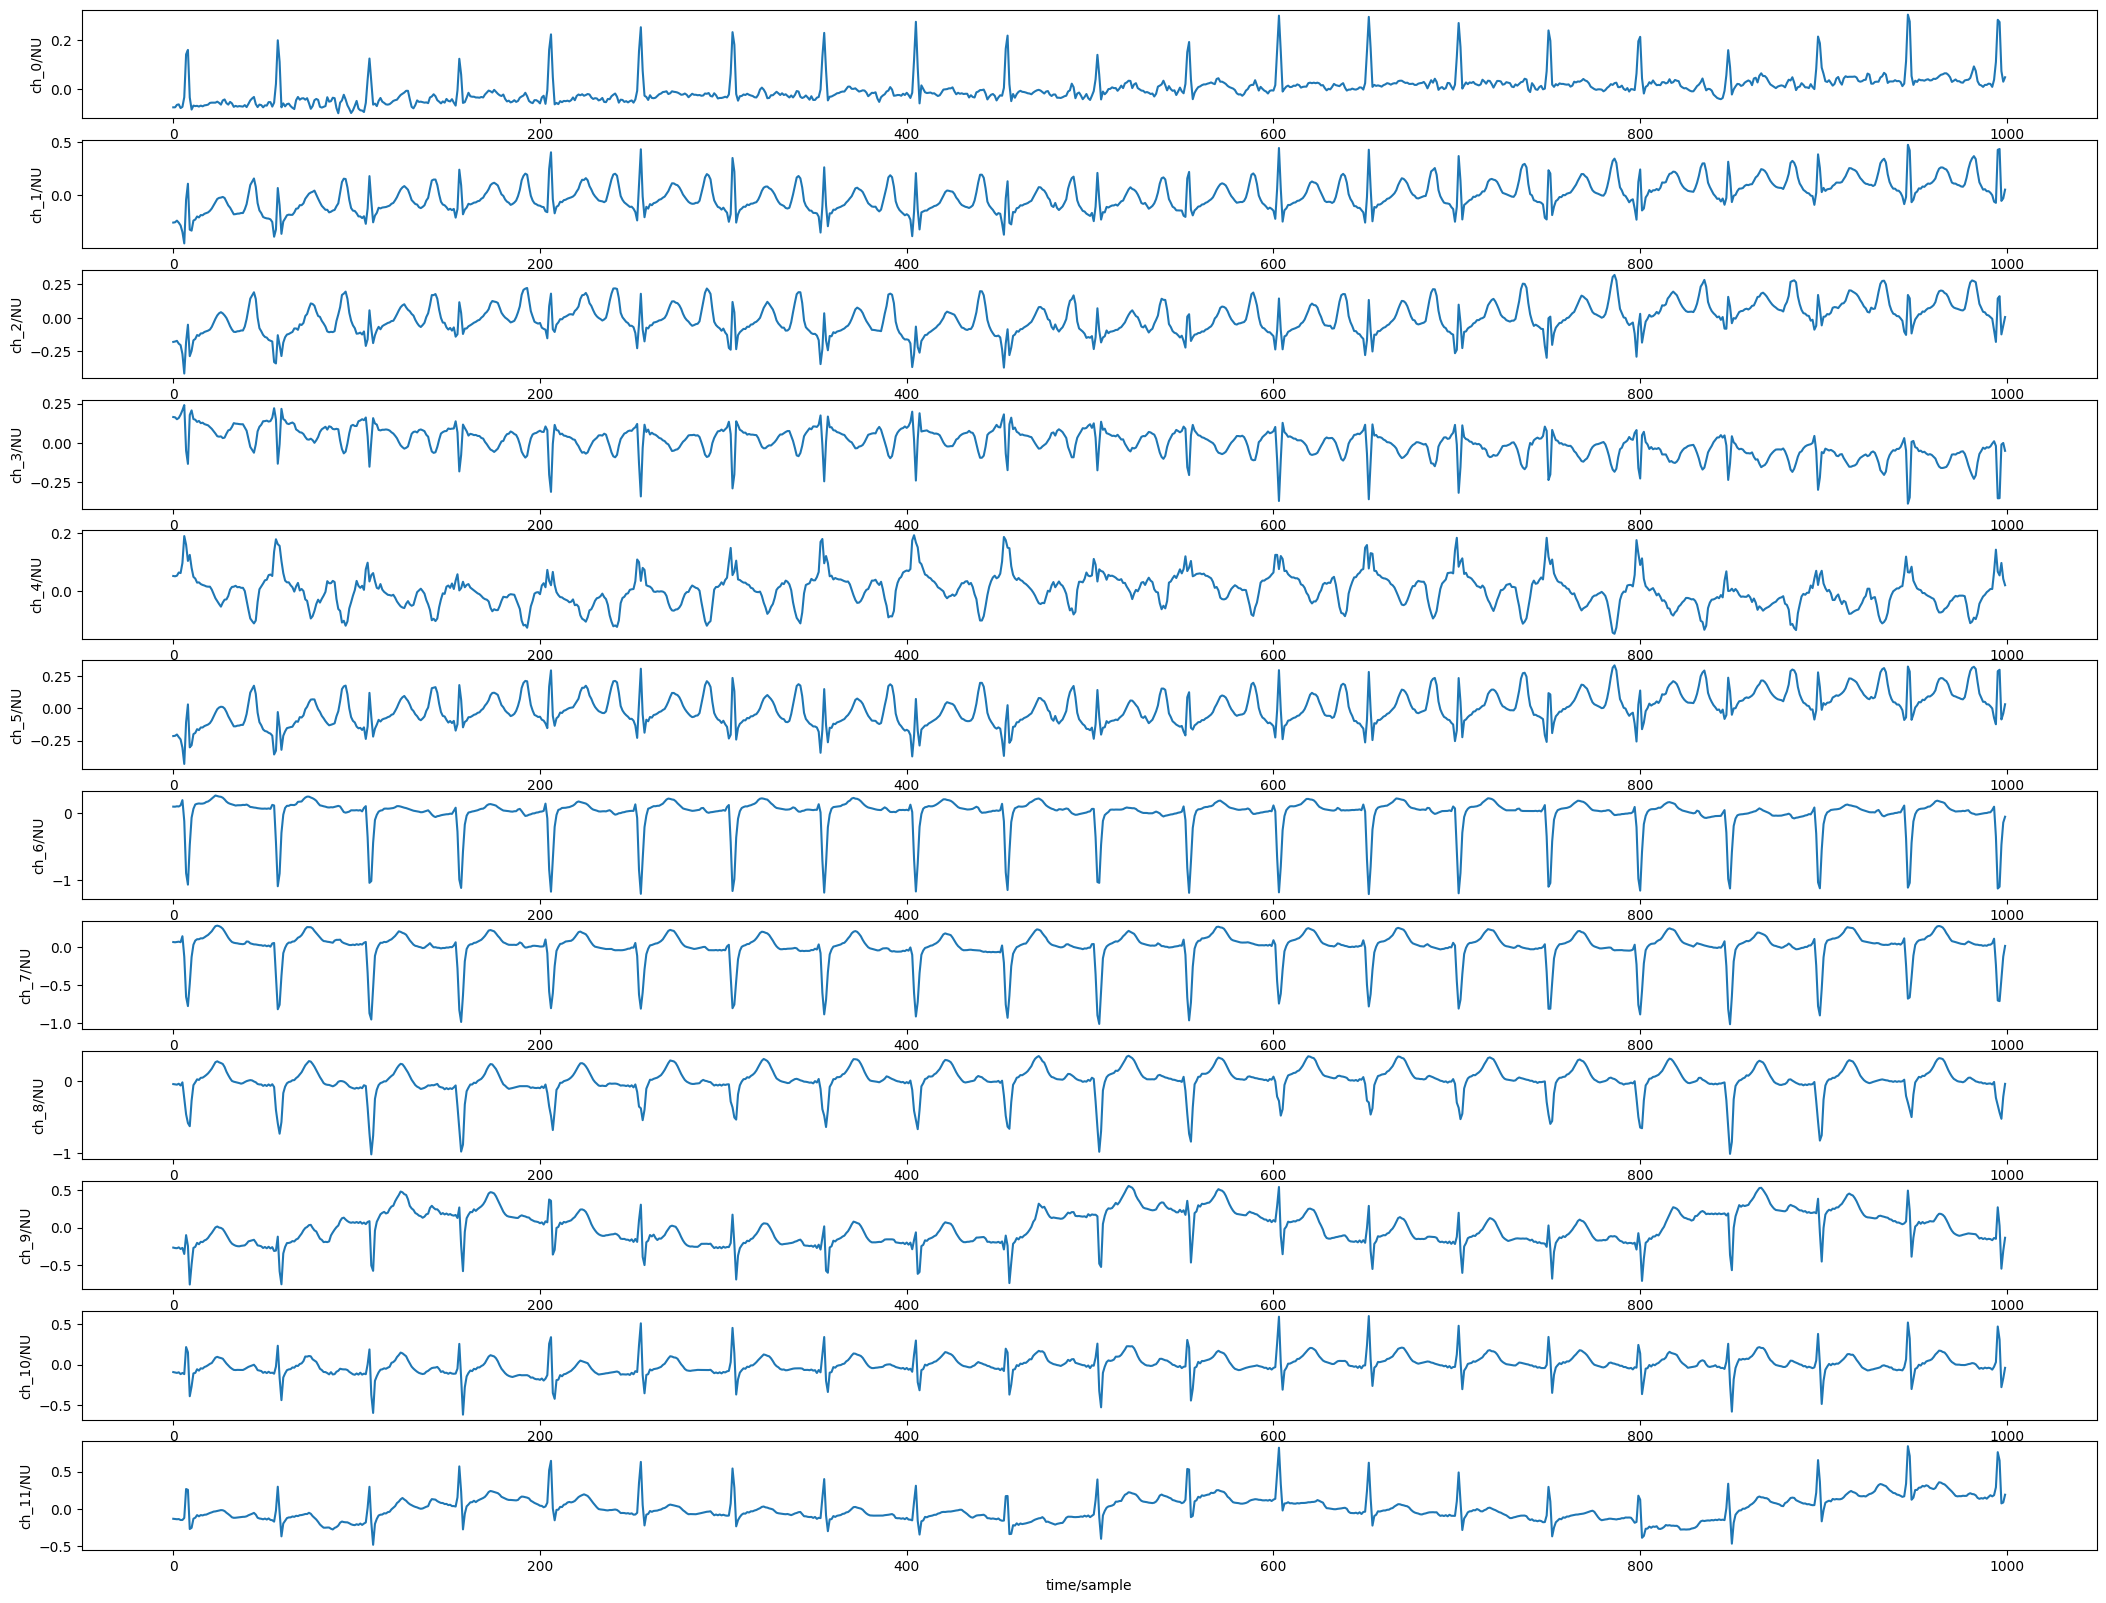